question from: https://www.kaggle.com/c/facial-keypoints-detection/data

solution from: https://github.com/erhwenkuo/deep-learning-with-keras-notebooks/blob/master/2.4-facial-keypoints-recognition.ipynb

In [2]:
import os
import sys
from datetime import datetime
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# 資料路徑
FTRAIN = 'data/training.csv'
FTEST = 'data/test.csv'
FLOOKUP = 'data/IdLookupTable.csv'

In [3]:
def load(test=False, cols=None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = pd.read_csv(fname)
    
    # Image欄位有像素的資料(pixel values)並轉換成 numpy arrays
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    
    # 提取特定欄位相關的數據
    if cols:
        df = df[list(cols) + ['Image']]
        
    print(df.count()) # 資料集的筆數
    df = df.dropna() # 刪除其中缺少值的資料
    
    X = np.vstack(df['Image'].values) / 255. # 將像素值進行歸一化 [0, 1]
    X = X.astype(np.float32) # 轉換資料型態
    
    if not test: # 只有 FTRAIN有目標的標籤(label)
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48
        X, y = shuffle(X, y, random_state=42) # 對資料進行洗牌
        y = y.astype(np.float32)
    else:
        y = None
        
    return X, y

def load2d(test=False, cols=None):
    X, y = load(test=test, cols=cols)
    X = X.reshape(-1, 96, 96, 1) # 轉換成Conv2D的卷積層的input shape
    
    return X, y

## 第一個模型: 只有單一的隱藏層(hidden layer)

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(9216,)))
model.add(Dense(30)) # 因為有15個關鍵座標(x,y), 共30個座標點要預測

sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd) # 使用"MSE"來做為loss function

model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               921700    
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
Total params: 924,730
Trainable params: 924,730
Non-trainable params: 0
_________________________________________________________________


In [5]:
# 載入模型訓練資料
X, y = load()

print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(y.shape, y.min(), y.max()))

# 設定訓練參數
batch_size = 32
epochs = 100

# 開始訓練
history = model.fit(X, y,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2 # 保留20%用來驗證
                   )

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

1712/1712 [==============================] - 0s 82us/step - loss: 0.0031 - val_loss: 0.0040
Epoch 68/100
1712/1712 [==============================] - 0s 82us/step - loss: 0.0031 - val_loss: 0.0040
Epoch 69/100
1712/1712 [==============================] - 0s 81us/step - loss: 0.0031 - val_loss: 0.0039
Epoch 70/100
1712/1712 [==============================] - 0s 80us/step - loss: 0.0030 - val_loss: 0.0040
Epoch 71/100
1712/1712 [==============================] - 0s 95us/step - loss: 0.0030 - val_loss: 0.0038
Epoch 72/100
1712/1712 [==============================] - 0s 89us/step - loss: 0.0031 - val_loss: 0.0039
Epoch 73/100
1712/1712 [==============================] - 0s 83us/step - loss: 0.0030 - val_loss: 0.0040
Epoch 74/100
1712/1712 [==============================] - 0s 82us/step - loss: 0.0030 - val_loss: 0.0040
Epoch 75/100
1712/1712 [==============================] - 0s 82us/step - loss: 0.0029 - val_loss: 0.0039
Epoch 76/100
1712/1712 [==============================] - 0s 81us/st

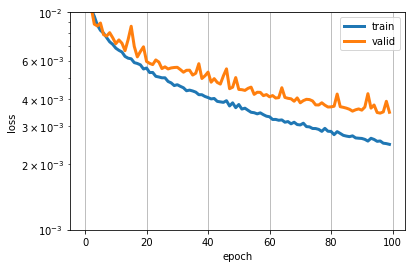

In [6]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, linewidth=3, label='train')
plt.plot(val_loss, linewidth=3, label='valid')
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(1e-3, 1e-2)
plt.yscale('log') # 由於整個loss的range很大, 我們使用'log'尺規來轉換
plt.show()

In [7]:
X_test, _ = load(test=True) # 取得測試資料集
y_pred = model.predict(X_test) # 進行預測

ImageId    1783
Image      1783
dtype: int64


In [8]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96) # 圖像是96x96
    axis.imshow(img, cmap='gray') # 以灰階來顯示
    
    # 把模型預測出來的15個臉部關鍵點打印在圖像上
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

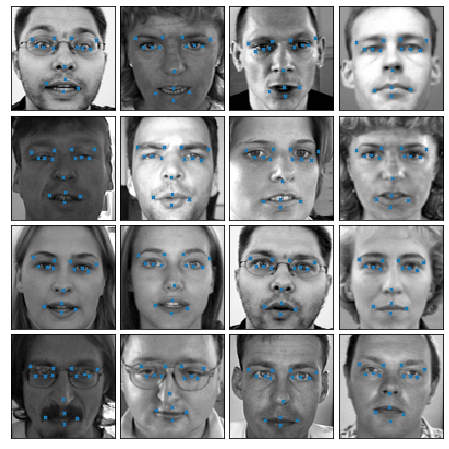

In [9]:
# 打印一個6x6的圖像框格
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# 選出測試圖像的前16個進行視覺化
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X_test[i], y_pred[i], ax)

plt.show()

## 第2個模型: 卷積網絡

In [10]:
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.model_selection import train_test_split

In [11]:
# 擴展keras的ImageDataGenerator來產生更多的圖像資料
class FlippedImageDataGenerator(ImageDataGenerator):
    # 由於臉部的關鍵點是左右對應的, 我們將使用鏡像(flip)的手法來產生圖像
    flip_indices = [(0, 2), (1, 3), (4, 8), (5, 9),
                    (6, 10), (7, 11), (12, 16), (13, 17),
                    (14, 18), (15, 19), (22, 24), (23, 25)]
    
    def next(self):
        X_batch, y_batch = super(FlippedImageDataGenerator, self).next()
        batch_size = X_batch.shape[0]
        # 隨機選擇一些圖像來進行水平鏡像(flip)
        indices = np.random.choice(batch_size, batch_size / 2, replace=False)
        X_batch[indices] = X_batch[indices, :, :, ::-1]
        
        # 對於有進行過水平鏡像的圖像, 也把臉部關鍵座標點進行調換
        if y_batch is not None:
            y_batch[indices, ::2] = y_batch[indices, ::2] * -1

            for a, b in self.flip_indices:
                y_batch[indices, a], y_batch[indices, b] = (
                    y_batch[indices, b], y_batch[indices, a]
                )

        return X_batch, y_batch

In [12]:
def cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), 
                     padding='same', activation='relu', 
                     kernel_initializer='he_normal', input_shape=(96,96,1)))
    
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(30)) # 因為有15個關鍵座標(x,y), 共30個座標點要預測
    
    return model;

# 取得模型
model2 = cnn_model()

# 秀出模型架構
model2.summary()

# 使用與第1個模型相同的optimer與loss function
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model2.compile(loss='mean_squared_error', optimizer=sgd) # 使用"MSE"來做為loss function

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 94, 94, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 45, 45, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)       

In [13]:
# 載入模型訓練資料
X, y = load2d()

# 進行資料拆分
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 設定訓練參數
epochs = 100

# 產生一個圖像產生器instance
flipgen = FlippedImageDataGenerator()

# 開始訓練
history = model2.fit_generator(flipgen.flow(X_train, y_train),
                               steps_per_epoch=len(X_train),
                               epochs=epochs, 
                               validation_data=(X_val, y_val)
                              )

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

1712/1712 [==============================] - 42s 24ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 69/100
1712/1712 [==============================] - 42s 24ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 70/100
1712/1712 [==============================] - 42s 24ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 71/100
1712/1712 [==============================] - 42s 24ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 72/100
1712/1712 [==============================] - 42s 24ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 73/100
1712/1712 [==============================] - 42s 24ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 74/100
1712/1712 [==============================] - 42s 24ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 75/100
1712/1712 [==============================] - 42s 24ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 76/100
1712/1712 [==============================] - 42s 24ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 77/100
1712/1712 [==============================] - 4

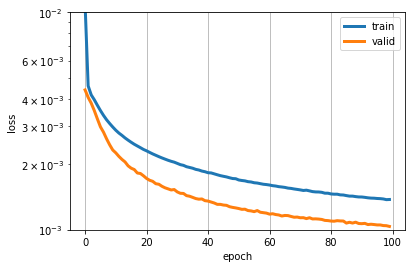

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, linewidth=3, label='train')
plt.plot(val_loss, linewidth=3, label='valid')
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(1e-3, 1e-2)
plt.yscale('log') # 由於整個loss的range很大, 我們使用'log'尺規來轉換
plt.show()

In [15]:
X_test2, _ = load2d(test=True) # 取得測試資料集
y_pred2 = model2.predict(X_test2) # 進行預測

ImageId    1783
Image      1783
dtype: int64


In [16]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96) # 圖像是96x96
    axis.imshow(img, cmap='gray') # 以灰階來顯示
    
    # 把模型預測出來的15個臉部關鍵點打印在圖像上
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

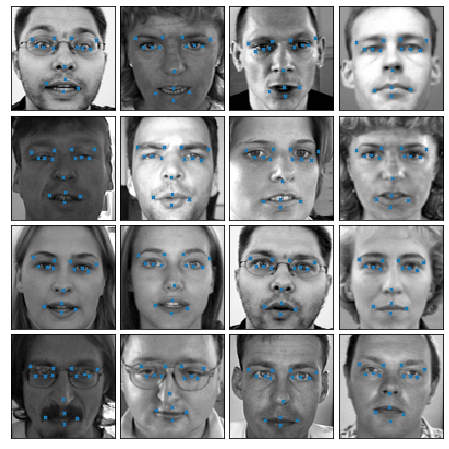

In [17]:
# 打印一個6x6的圖像框格
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# 選出測試圖像的前16個進行視覺化
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X_test[i], y_pred[i], ax)

plt.show()

## 視覺化兩個模型的預測結果

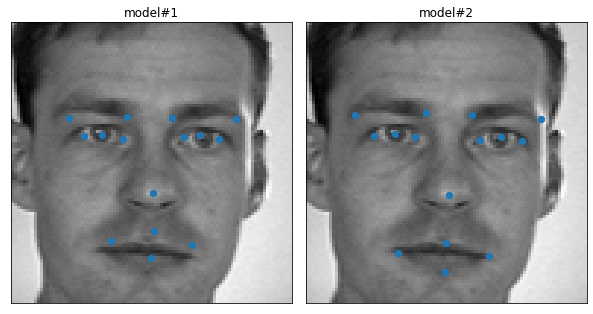

In [18]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96) # 圖像是96x96
    axis.imshow(img, cmap='gray') # 以灰階來顯示
    
    # 把模型預測出來的15個臉部關鍵點打印在圖像上
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='o', s=40)
    
fig = plt.figure(figsize=(8, 8))

idx = 30 # 我們找一張圖像來比較兩個模型預測的結果

fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# 第一個模型
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('model#1')
plot_sample(X_test[idx], y_pred[idx], ax)

# 第二個模型
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('model#2')
plot_sample(X_test2[idx], y_pred2[idx], ax)
 
plt.show()

In [19]:
columns=["left_eye_center_x","left_eye_center_y","right_eye_center_x","right_eye_center_y","left_eye_inner_corner_x","left_eye_inner_corner_y","left_eye_outer_corner_x","left_eye_outer_corner_y","right_eye_inner_corner_x","right_eye_inner_corner_y","right_eye_outer_corner_x","right_eye_outer_corner_y","left_eyebrow_inner_end_x","left_eyebrow_inner_end_y","left_eyebrow_outer_end_x","left_eyebrow_outer_end_y","right_eyebrow_inner_end_x","right_eyebrow_inner_end_y","right_eyebrow_outer_end_x","right_eyebrow_outer_end_y","nose_tip_x","nose_tip_y","mouth_left_corner_x","mouth_left_corner_y","mouth_right_corner_x","mouth_right_corner_y","mouth_center_top_lip_x","mouth_center_top_lip_y","mouth_center_bottom_lip_x","mouth_center_bottom_lip_y"]
y_pred_final = y_pred2 * 48 + 48
y_pred_final = y_pred_final.clip(0,96) # 因為圖像為96x96, 因此座標點只能落在[0~96]
df = DataFrame(y_pred_final, columns=columns)
lookup_table = pd.read_csv(FLOOKUP)
values = []

for index, row in lookup_table.iterrows():
    values.append((row['RowId'], df.iloc[row.ImageId - 1][row.FeatureName]))
    
now_str = datetime.now().isoformat().replace(':','-')
submission = DataFrame(values, columns=('RowId', 'Location'))
filename = 'submission-{}.csv'.format(now_str)
submission.to_csv(filename, index=False)
print("Wrote {}".format(filename))

Wrote submission-2019-12-14T08-59-44.847908.csv
